In [ ]:
%%capture
!pip install transformers datasets

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
import random

from tqdm.notebook import tqdm
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

We use the same dataset as before: imdb. The first following cells are very similar to what we did in the HW 1, except that we pool the dataset from the HugginFace hub, using the special `load_dataset` function.


# Data loading


In [ ]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
print("Type of the tokenizer:", type(tokenizer.vocab))
print(tokenizer.vocab_size) # faster implementation of the previous one
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)
print(str(tokenizer.vocab)[:100])

Type of the tokenizer: <class 'collections.OrderedDict'>
30522
Length of the vocabulary: 30522
OrderedDict([('[PAD]', 0), ('[unused0]', 1), ('[unused1]', 2), ('[unused2]', 3), ('[unused3]', 4), (


In [ ]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"] # tokenizer returns a dictionary when you can visualize the token_in_ids
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [ ]:
tokenizer(dataset[0]["review"])

{'input_ids': [101, 2028, 1997, 1996, 2060, 15814, 2038, 3855, 2008, 2044, 3666, 2074, 1015, 11472, 2792, 2017, 1005, 2222, 2022, 13322, 1012, 2027, 2024, 2157, 1010, 2004, 2023, 2003, 3599, 2054, 3047, 2007, 2033, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2034, 2518, 2008, 4930, 2033, 2055, 11472, 2001, 2049, 24083, 1998, 4895, 10258, 2378, 8450, 5019, 1997, 4808, 1010, 2029, 2275, 1999, 2157, 2013, 1996, 2773, 2175, 1012, 3404, 2033, 1010, 2023, 2003, 2025, 1037, 2265, 2005, 1996, 8143, 18627, 2030, 5199, 3593, 1012, 2023, 2265, 8005, 2053, 17957, 2007, 12362, 2000, 5850, 1010, 3348, 2030, 4808, 1012, 2049, 2003, 13076, 1010, 1999, 1996, 4438, 2224, 1997, 1996, 2773, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2009, 2003, 2170, 11472, 2004, 2008, 2003, 1996, 8367, 2445, 2000, 1996, 17411, 4555, 3036, 2110, 7279, 4221, 12380, 2854, 1012, 2009, 7679, 3701, 2006, 14110, 2103, 1010, 2019, 6388, 2930, 1997, 1996, 3827, 2073, 2035, 1996, 4442, 2031, 3221, 21430,

In [ ]:
preprocessing_fn(dataset[0], tokenizer)

{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

Be sure, you understand this output.

Now we can really prepare the data for the NNet.


Now we can really prepare the data for the NNet.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [ ]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
shu_dataset = dataset.shuffle(seed = 123) # very important to shuffle the dataset
# Select 5000 samples
shu_dataset = shu_dataset.select(random.sample(range(1, dataset.num_rows), n_samples))


# Tokenize the dataset
tok_dataset = shu_dataset.map(preprocessing_fn, fn_kwargs = {"tokenizer":tokenizer}) # map function is massive
# Remove useless columns

new_dataset = tok_dataset.remove_columns(["review", "sentiment"])

# Split the train and validation
dataset2 = new_dataset.train_test_split(test_size = 0.2)

train_set = dataset2["train"]
valid_set = dataset2["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
n_train = len(train_set)
n_valid = len(valid_set)
print(n_train, n_valid)

4000 1000


The dataset now outputs list of ids. However, there is one last remaining step. Since we want to have batch of tensors, they should have the same size.

Below is a code for padding batch of lists to the same size.



In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        ) # we apply this padding sequence in order to have sequences of ids of the same length
        label = torch.tensor([x["label"] for x in batch])[:, None] # we are making it as a column vector
        return {"review_ids": features["input_ids"], "label": label}

Let's define the `DataLoaders`.

In [ ]:
data_collator = DataCollator(tokenizer)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

Print various information about one batch.

Explore the variables and understand what's inside.

In [ ]:
batch = next(iter(train_dataloader))
print(batch["review_ids"]) # all the sampled texts
print(batch["review_ids"].shape) # 32 rows and 256 elements
# PAD has the symbol zero because it is a meaningless symbol

print(batch["label"].size()) # associated label as a column vector --> it is bidimensional so we can have some problems dealing with it

tensor([[ 1999,  3666,  2023,  ...,  1996,  3959,  1997],
        [23995,  3345, 27307,  ...,     0,     0,     0],
        [ 2009,  2001,  2061,  ...,  1028,  1026,  7987],
        ...,
        [ 2672,  2057, 17151,  ..., 17417,  1007,  2040],
        [ 2009,  1005,  1055,  ...,  2000,  2156,  1996],
        [ 2023,  2143,  2003,  ...,  1013,  1028,  1026]])
torch.Size([32, 256])
torch.Size([32, 1])


# Convolution model
Now, we are done with the data and we have our interface for the model, but we need to build the model.
Here the sequence of operation the model will achieve:  
- Embedding
- Convolution (1D)
- Pooling
- Linear


- Write a function **load_model** that takes a path to a saved Word2Vec
embeddings (with the previous formatting) and loads the checkpoint the
embeddings directly to the ConvolutionModel (you can use either the
state-of-the art model or the first small model).

We decide to use the first small model with a convolutional layer, an activation function, a max pooling over time, a dropout and a linear transformation. We do not apply directly the softmax because the Cross-entropy does it.

In [ ]:
def load_model(file_path): # very basic function
  fun = torch.load(file_path)
  return fun.weight

In [ ]:
load_model("/content/model_dim-25_radius-4_ratio-2-batch-256-epoch-3.ckpt")

Parameter containing:
tensor([[-0.0957, -0.6984,  0.7036,  ...,  0.5603, -1.3484, -0.7887],
        [-0.4279, -0.1765,  1.1122,  ..., -1.5147,  1.7830, -0.1587],
        [-0.0652, -0.4564,  0.0320,  ..., -0.8620,  0.1168, -1.2251],
        ...,
        [ 0.1597, -0.7585, -0.9452,  ...,  0.7615, -0.1928, -0.5954],
        [-0.5314, -0.2114,  0.3615,  ...,  0.6649,  0.2359, -0.7778],
        [ 0.4482,  0.6211,  0.5739,  ..., -1.6013,  1.2308, -1.3729]])

# Training the model

To train the model, we need to define a loss function and an optimizer. As loss function we choose the crossentropy and as optimizer we choose ADAM

- Train the model, initialized with these emebeddings.

In [ ]:
batch_size = 16 # fix a batch size
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)


We will train and test different models with different values for the hyperparameters:
 - radius $=\{4, 6\}$
 - scale $=\{2, 4\}$
 - embedding_dimension $=\{25, 100\}$

In [ ]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, path, vocab_size, embedding_dim = 5, feature_size = 100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embedding = nn.Embedding.from_pretrained(load_model(path), freeze = True)
        self.conv = nn.Conv1d(in_channels = self.embedding_dim, out_channels = self.feature_size, kernel_size = kernel_size, padding = (kernel_size - 1)//2, bias=True)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = self.feature_size, out_features = 2)


    def forward(self, input_ids):
        # TODO
        embedded = self.embedding(input_ids).permute(0, 2, 1) # we need to change the position between embeddings and sequence lenght
        # this is mandatory for the structure of our data
        x = self.conv(embedded)
        relu = F.relu(x)
        x1,_ = torch.max(relu, dim = 2) # max pooling over the embeddings --> it is the same as using the adaptive max pooling function
        x1 = self.dropout(x1)
        linear = self.linear(x1)
        return linear

In [ ]:
n_epochs = 5 # the number of training epochs

def validation(valid, mod):
  correct = 0
  preds_for_confusion2 = torch.empty(n_valid, dtype=torch.int32) # we will display later a confusion matrix
  labels_for_confusion2 = torch.empty(n_valid, dtype=torch.int32)
  criterion = torch.nn.CrossEntropyLoss() #crossentropy loss
  mod.eval()
  with torch.no_grad():
    i = -1
    for batch in tqdm(valid):
      i += 1
      input_ids = batch["review_ids"]
      labels = batch["label"]
      labels = labels.squeeze(1)
      labels_size = labels.size()[0]
      labels_for_confusion2[i*labels_size: (i+1)*labels_size] = labels

      out = mod(input_ids)
      _,preds = torch.max(out.data, 1)
      correct += (preds == labels).sum().item()

      preds_size = preds.size()[0]
      preds_for_confusion2[i*preds_size: (i+1)*preds_size] = preds

  print(f"The validation accuracy is {correct/n_valid}")
  mod.train()
  return (preds_for_confusion2, labels_for_confusion2)

def training(epo, mod, train, valid):
  optimizer = torch.optim.Adam(mod.parameters(), lr = 0.001, eps = 1e-08)
  criterion = torch.nn.CrossEntropyLoss()
  for e in range(epo):
    mod.train()
    running_loss = 0
    correct = 0
    for batch in tqdm(train):
      input_ids = batch["review_ids"]
      labels = batch["label"]
      labels = labels.squeeze(1)
      optimizer.zero_grad()
      out = mod(input_ids)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      _,preds = torch.max(out.data, 1) # take the position of the max
      running_loss += loss.data.item()
      correct += (preds == labels).sum().item() # compare with the original labels

    running_loss /= n_train
    correct = correct /n_train
    print(f"For the epoch {e}, Loss:{running_loss} and accuracy {correct}")
  return validation(valid, mod)


- Model with radius equal to $4$, scale equal to $2$ and dimension equal to $25$;

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04490599776804447 and accuracy 0.52025


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.04294700922071934 and accuracy 0.55575


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.04172876922786236 and accuracy 0.59775


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.0405057357698679 and accuracy 0.62175


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.03863131628185511 and accuracy 0.66725


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.592


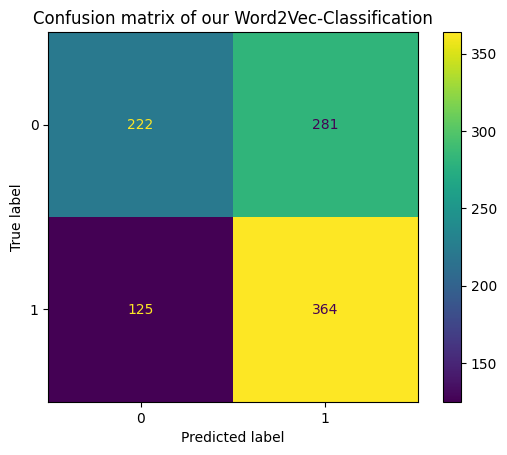

In [ ]:
model1 = Conv1dClassifier(path = "/content/model_dim-25_radius-4_ratio-2-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 25
)
training1 = training(n_epochs, model1, train_dataloader, valid_dataloader )
preds_conf2 = training1[0].to(dtype=torch.int32).numpy()
labels_conf2 = training1[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $2$, radius equal to $4$ and dimension equal to $100$;

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04417783322930336 and accuracy 0.54525


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.037087553031742576 and accuracy 0.689


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.03187292341142893 and accuracy 0.75675


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.025595716640353202 and accuracy 0.82525


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.02119321251474321 and accuracy 0.86275


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.72


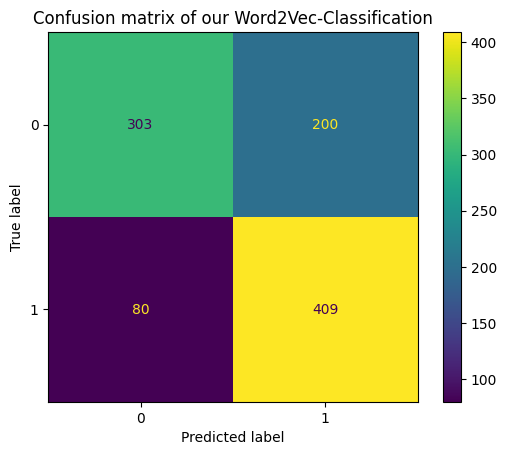

In [ ]:
model2 = Conv1dClassifier(path = "/content/model_dim-100_radius-4_ratio-2-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 100
)
training2 = training(n_epochs, model2, train_dataloader, valid_dataloader )
preds_conf2 = training2[0].to(dtype=torch.int32).numpy()
labels_conf2 = training2[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $2$, radius equal to $6$ and dimension equal to $25$;

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.044790722757577894 and accuracy 0.51275


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.042084801129996775 and accuracy 0.56775


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.041227812871336936 and accuracy 0.606


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.03994054838269949 and accuracy 0.6345


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.03874426548928022 and accuracy 0.65725


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.589


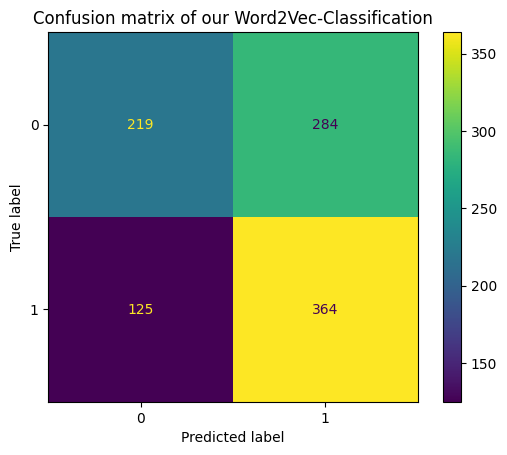

In [ ]:
model3 = Conv1dClassifier(path = "/content/model_dim-25_radius-6_ratio-2-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 25
)
training3 = training(n_epochs, model3, train_dataloader, valid_dataloader )
preds_conf2 = training3[0].to(dtype=torch.int32).numpy()
labels_conf2 = training3[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $2$, radius equal to $6$ and dimension equal to $100$;

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04391154459118843 and accuracy 0.547


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.03814961243420839 and accuracy 0.6685


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.03217921677231789 and accuracy 0.76


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.025555401600897313 and accuracy 0.83075


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.019614184431731702 and accuracy 0.87825


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.685


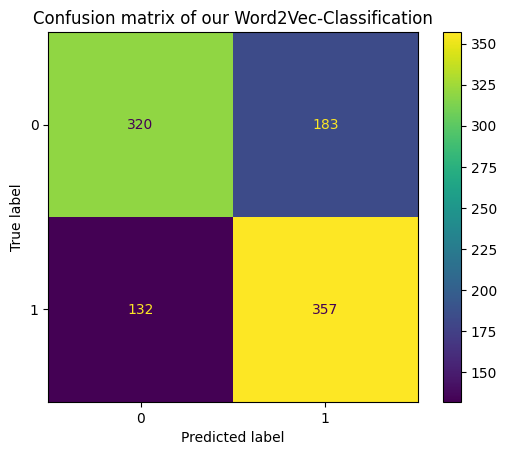

In [ ]:
model4 = Conv1dClassifier(path = "/content/model_dim-100_radius-6_ratio-2-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 100
)
training4 = training(n_epochs, model4, train_dataloader, valid_dataloader )
preds_conf2 = training4[0].to(dtype=torch.int32).numpy()
labels_conf2 = training4[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $4$, radius equal to $4$ and dim equal to $25$

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04486522163450718 and accuracy 0.51325


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.04262114392220974 and accuracy 0.568


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.041613023564219476 and accuracy 0.59725


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.04074930086731911 and accuracy 0.62325


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.03910282627493143 and accuracy 0.655


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.587


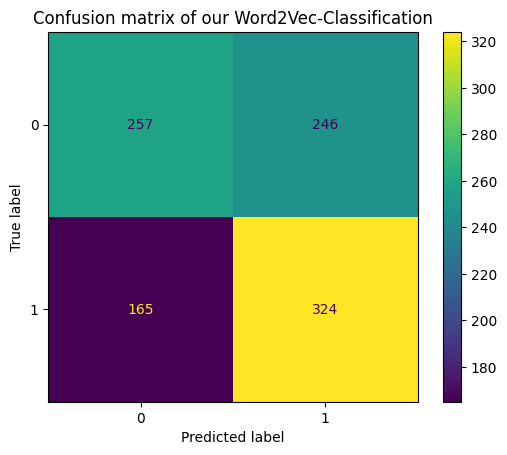

In [ ]:
model5 = Conv1dClassifier(path = "/content/model_dim-25_radius-4_ratio-4-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 25
)
training5 = training(n_epochs, model5, train_dataloader, valid_dataloader )
preds_conf2 = training5[0].to(dtype=torch.int32).numpy()
labels_conf2 = training5[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $4$, radius equal to $4$ and dim equal to $100$

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04450669388473034 and accuracy 0.519


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.03933176775276661 and accuracy 0.655


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.03318134058266878 and accuracy 0.7535


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.02646510858088732 and accuracy 0.82


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.020015375021845104 and accuracy 0.8805


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.662


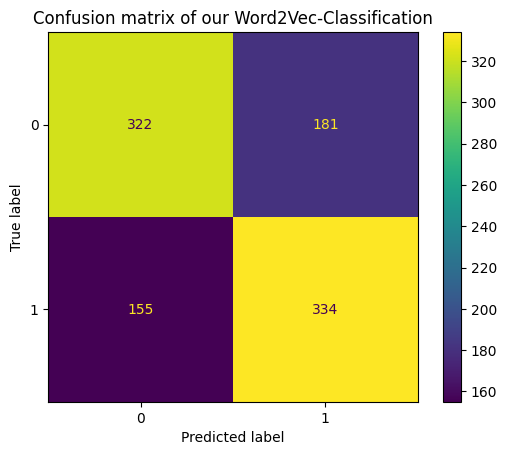

In [ ]:
model6 = Conv1dClassifier(path = "/content/model_dim-100_radius-4_ratio-4-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 100
)
training6 = training(n_epochs, model6, train_dataloader, valid_dataloader)
preds_conf2 = training6[0].to(dtype=torch.int32).numpy()
labels_conf2 = training6[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $4$, radius equal to $6$ and dim equal to $25$

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04445082759857178 and accuracy 0.52175


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.042317594185471534 and accuracy 0.57025


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.04104624935984612 and accuracy 0.60525


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.040041322581470015 and accuracy 0.62375


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.0384536415413022 and accuracy 0.65825


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.614


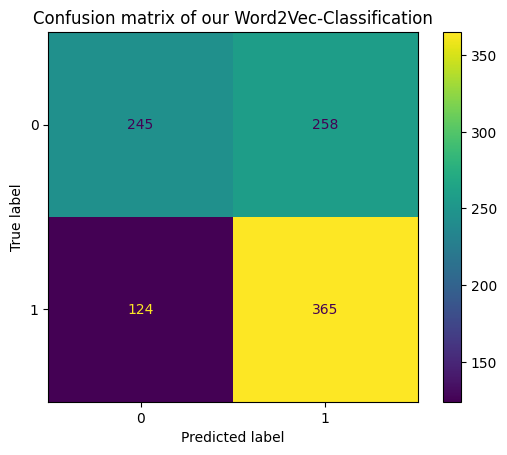

In [ ]:
model7 = Conv1dClassifier(path = "/content/model_dim-25_radius-6_ratio-4-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 25
)
training7 = training(n_epochs, model7, train_dataloader, valid_dataloader )
preds_conf2 = training7[0].to(dtype=torch.int32).numpy()
labels_conf2 = training7[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

- Model with scale equal to $4$, radius equal to $6$ and dim equal to $100$

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04470425121486187 and accuracy 0.52425


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.038875249020755294 and accuracy 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.03271778883039951 and accuracy 0.75875


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.025254182320088147 and accuracy 0.83425


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.019838456751778723 and accuracy 0.8835


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.67


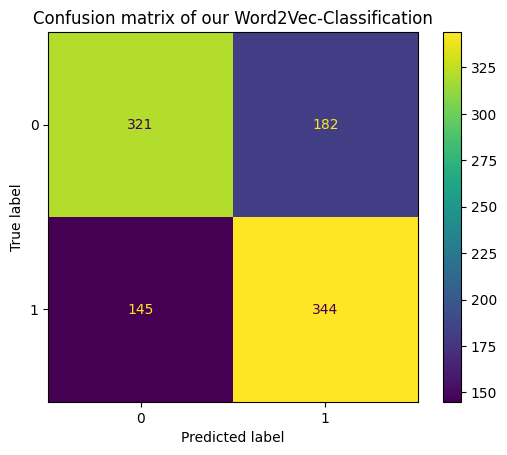

In [ ]:
model8 = Conv1dClassifier(path = "/content/model_dim-100_radius-6_ratio-4-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 100
)
training8 = training(n_epochs, model8, train_dataloader, valid_dataloader )
preds_conf2 = training8[0].to(dtype=torch.int32).numpy()
labels_conf2 = training8[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()


- Compare the results with the model without this initialization.

In [ ]:
class Conv1dClassifier2(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim = 5, feature_size = 100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embedding = nn.Embedding(num_embeddings = VOCSIZE, embedding_dim = self.embedding_dim)
        self.conv = nn.Conv1d(in_channels = self.embedding_dim, out_channels = self.feature_size, kernel_size = kernel_size, padding = (kernel_size - 1)//2, bias=True)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = self.feature_size, out_features = 2)


    def forward(self, input_ids):
        # TODO
        embedded = self.embedding(input_ids).permute(0, 2, 1)
        # this is mandatory for the structure of our data
        x = self.conv(embedded)
        relu = F.relu(x)
        x1,_ = torch.max(relu, dim = 2)
        x1 = self.dropout(x1)
        linear = self.linear(x1)
        return linear

In [ ]:
model22 = Conv1dClassifier2(
    vocab_size = VOCSIZE, embedding_dim = 25
) # model with 25 embeddings

In [ ]:
## Define the training loss
criterion = torch.nn.CrossEntropyLoss()
## The optimizer
optimizer = torch.optim.Adam(model22.parameters(), lr = 0.0001, eps = 1e-08)

n_epochs = 5 # the number of training epochs
for e in range(n_epochs):
    model22.train()
    running_loss = 0
    correct = 0
    for batch in tqdm(train_dataloader):
      input_ids = batch["review_ids"]
      labels = batch["label"]
      labels = labels.squeeze(1)
      optimizer.zero_grad()
      out = model22(input_ids)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

      _,preds = torch.max(out.data, 1)
      running_loss += loss.data.item()
      correct += (preds == labels).sum().item()

    running_loss /= n_train
    correct = correct /n_train
    print(f" For the epoch {e}, Loss:{running_loss} and accuracy {correct}")

preds_for_confusion = torch.empty(n_valid, dtype=torch.int32) # we will display later a confusion matrix
labels_for_confusion = torch.empty(n_valid, dtype=torch.int32)


with torch.no_grad():
  preds_for_confusion = torch.empty(n_valid, dtype=torch.int32) # we will display later a confusion matrix
  labels_for_confusion = torch.empty(n_valid, dtype=torch.int32)
  correct = 0
  number = 0
  i = -1
  for batch in valid_dataloader:
    i += 1
    input_ids = batch["review_ids"]
    labels = batch["label"]
    labels = labels.squeeze(1)
    labels_size = labels.size()[0]
    labels_for_confusion[i*labels_size: (i+1)*labels_size] = labels

    out = model22(input_ids)
    _,preds = torch.max(out.data, 1)
    preds_size = preds.size()[0]

    preds_for_confusion[i*preds_size: (i+1)*preds_size] = preds
    number += labels.size(0)
    correct += (preds == labels).sum().item()
  print(f"The validation accuracy is {correct/n_valid}")


  0%|          | 0/250 [00:00<?, ?it/s]

 For the epoch 0, Loss:0.048189224034547805 and accuracy 0.5125


  0%|          | 0/250 [00:00<?, ?it/s]

 For the epoch 1, Loss:0.04762207795679569 and accuracy 0.50925


  0%|          | 0/250 [00:00<?, ?it/s]

 For the epoch 2, Loss:0.04626417762041092 and accuracy 0.526


  0%|          | 0/250 [00:00<?, ?it/s]

 For the epoch 3, Loss:0.045958790868520734 and accuracy 0.523


  0%|          | 0/250 [00:00<?, ?it/s]

 For the epoch 4, Loss:0.044883147336542605 and accuracy 0.535
The validation accuracy is 0.531


In [ ]:
preds_conf = preds_for_confusion.to(dtype=torch.int32).numpy()
labels_conf = labels_for_confusion.to(dtype=torch.int32).numpy()

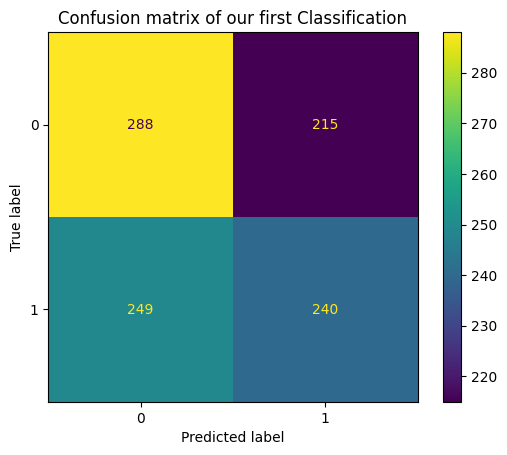

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_conf, preds_conf, labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot()
plt.title('Confusion matrix of our first Classification')
plt.show()

In [ ]:
model100 = Conv1dClassifier2(
    vocab_size = VOCSIZE, embedding_dim = 100
) # model with 100 embeddings


In [ ]:
## Define the training loss
criterion = torch.nn.CrossEntropyLoss()
## The optimizer
optimizer = torch.optim.Adam(model100.parameters(), lr = 0.0001, eps = 1e-08)

n_epochs = 5 # the number of training epochs
for e in range(n_epochs):
    model2.train()
    running_loss = 0
    correct = 0
    for batch in tqdm(train_dataloader):
      input_ids = batch["review_ids"]
      labels = batch["label"]
      labels = labels.squeeze(1)


      optimizer.zero_grad()
      out = model100(input_ids)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

      _,preds = torch.max(out.data, 1)
      running_loss += loss.data.item()
      correct += (preds == labels).sum().item()

    running_loss /= n_train
    correct = correct /n_train
    print(f"Loss:{running_loss} and accuracy {correct}")
correct = 0
number = 0
preds_for_confusion = torch.empty(n_valid, dtype=torch.int32) # we will display later a confusion matrix
labels_for_confusion = torch.empty(n_valid, dtype=torch.int32)


with torch.no_grad():
  i = -1
  for batch in tqdm(valid_dataloader):
    i += 1
    input_ids = batch["review_ids"]
    labels = batch["label"]
    labels = labels.squeeze(1)
    labels_size = labels.size()[0]
    labels_for_confusion[i*labels_size: (i+1)*labels_size] = labels

    out = model100(input_ids)
    _,preds = torch.max(out.data, 1)
    preds_size = preds.size()[0]

    preds_for_confusion[i*preds_size: (i+1)*preds_size] = preds
    number += labels.size(0)
    correct += (preds == labels).sum().item()
  print(f"The validation accuracy is {correct/n_valid}")

  0%|          | 0/250 [00:00<?, ?it/s]

Loss:0.04786045604944229 and accuracy 0.51175


  0%|          | 0/250 [00:00<?, ?it/s]

Loss:0.04591843298077583 and accuracy 0.535


  0%|          | 0/250 [00:00<?, ?it/s]

Loss:0.04289771793782711 and accuracy 0.57975


  0%|          | 0/250 [00:00<?, ?it/s]

Loss:0.04153065510839224 and accuracy 0.609


  0%|          | 0/250 [00:00<?, ?it/s]

Loss:0.040925630003213885 and accuracy 0.62325


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.577


In [ ]:
preds_conf = preds_for_confusion.to(dtype=torch.int32).numpy()
labels_conf = labels_for_confusion.to(dtype=torch.int32).numpy()

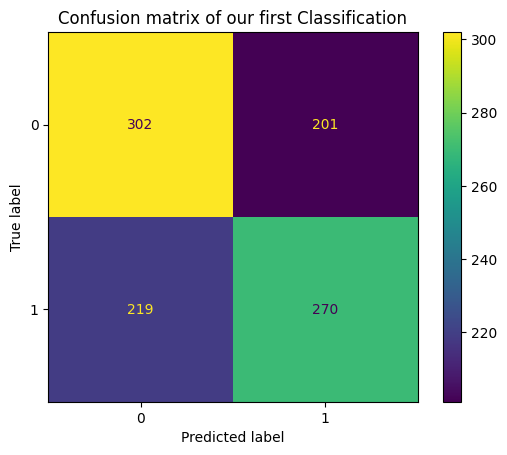

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_conf, preds_conf, labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot()
plt.title('Confusion matrix of our first Classification')
plt.show()

- Make a small ablation study on the influence of some parameters of the
Word2Vec model on the classification task. Analyze the results.

First of all, the most importand parameter in Word2vec is the number of embeddings. Here we choose to use relatively small number of embeddings, but usually a value greater than $100$ is suggested because lower values could hide something. However, those values depends also on the data. Taking into account the models with not initialized embeddings, we can state that the impact of the dimensionality of the embeddings is quite important. Moreover, the model with $25$ embeddings as a lower testing accuracy than the model with $100$ embeddings.


Above we define the different models initialized with different parameters for the embeddings, the radius of positive context and the scale of negative context.  From our small study, we can state that a model with an higher number of embeddings has a better permorfance in terms of accuracy. In fact, comparing models with same parameters but different number of embeddings, we see an increasing of accuracy despite of an increase in computational time (quite normal we would say).

Analyzing the results, it seems that when the embedding dimension is $25$, we obtain more less the same score as in the not initialized situation. While, when the number of embedings is $100$, suggested value, the initialized model tends to perform well than the other. In general, we can affirm that the model with the best performance is the one with $100$ embedding dimensions, trained with radius equal to $4$ and scale equal to $2$. It is also interesting to notice that even if we are using a quite simple model, we obtain a decent validation accuracy.



Here you can find the code to check the behaviour of the initialized model with $100$ embeddings dimension (scale equal to $2$ and radius equal to $4$, the best model) for different epochs values. We choose to decrease the value of the learning rate in order to avoid overprediction. We can affirm that after a certain number of epochs we reach a sort of stationarity condition around $0.75$.

In [ ]:
def valid_acc_num_epochs(n_epochs, model):
  # This function is going to plot the variation of the accuracy test on train and test datasets along the number of epochs
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-04, eps = 1e-08)
  ## Define the training loss
  criterion = torch.nn.CrossEntropyLoss()

  ## The optimizer
  correct_train = np.zeros(n_epochs)
  correct_valid = np.zeros(n_epochs)

  for e in range(n_epochs):
      model.train()
      running_loss = 0
      for batch in tqdm(train_dataloader):
        input_ids = batch["review_ids"]
        labels = batch["label"]
        labels = labels.squeeze(1)


        optimizer.zero_grad()
        out = model(input_ids)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        _,preds = torch.max(out.data, 1)
        running_loss += loss.data.item()
        correct_train[e] += (preds == labels).sum().item()

      running_loss /= n_train
      correct_train[e] = correct_train[e] /n_train
      print(f'Finish train {e} and acc : {correct_train[e]}')

    #for this number of epoch we check the accuracy test on test dataset
      number_valid = 0
      model.eval()
      with torch.no_grad():
        for batch in tqdm(valid_dataloader):
          input_ids = batch["review_ids"]
          labels = batch["label"]
          labels = labels.squeeze(1)

          out = model(input_ids)
          _,preds = torch.max(out.data, 1)
          number_valid += labels.size(0)
          correct_valid[e] += (preds == labels).sum().item()
      correct_valid[e] /= number_valid
      print(f'Acc test : {correct_valid[e]}')
  acc = np.zeros((2,n_epochs))
  acc[0,:] = correct_train
  acc[1,:] = correct_valid
  return acc



  #First train de model

In [ ]:
acc = valid_acc_num_epochs(40, Conv1dClassifier(path = "/content/model_dim-100_radius-4_ratio-2-batch-256-epoch-3.ckpt",
                                                vocab_size = VOCSIZE, embedding_dim = 100))

  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 0 and acc : 0.50925


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.537


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 1 and acc : 0.52775


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.559


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 2 and acc : 0.55175


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.573


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 3 and acc : 0.57675


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.59


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 4 and acc : 0.603


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.605


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 5 and acc : 0.629


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.64


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 6 and acc : 0.667


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.642


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 7 and acc : 0.66975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.677


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 8 and acc : 0.708


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.689


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 9 and acc : 0.712


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.694


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 10 and acc : 0.73825


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.711


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 11 and acc : 0.7545


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.709


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 12 and acc : 0.76425


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.738


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 13 and acc : 0.7735


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.722


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 14 and acc : 0.78575


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.739


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 15 and acc : 0.80225


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.748


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 16 and acc : 0.81275


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.748


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 17 and acc : 0.812


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.749


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 18 and acc : 0.8305


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.759


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 19 and acc : 0.83775


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.761


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 20 and acc : 0.84475


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.765


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 21 and acc : 0.85425


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.754


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 22 and acc : 0.853


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.762


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 23 and acc : 0.86725


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 24 and acc : 0.85975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 25 and acc : 0.869


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 26 and acc : 0.875


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.751


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 27 and acc : 0.88825


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 28 and acc : 0.8925


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 29 and acc : 0.89325


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.764


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 30 and acc : 0.8935


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.754


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 31 and acc : 0.9055


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.764


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 32 and acc : 0.90075


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.756


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 33 and acc : 0.921


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 34 and acc : 0.92225


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.76


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 35 and acc : 0.91975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.753


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 36 and acc : 0.9275


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.746


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 37 and acc : 0.917


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.759


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 38 and acc : 0.926


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.757


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 39 and acc : 0.9285


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.758


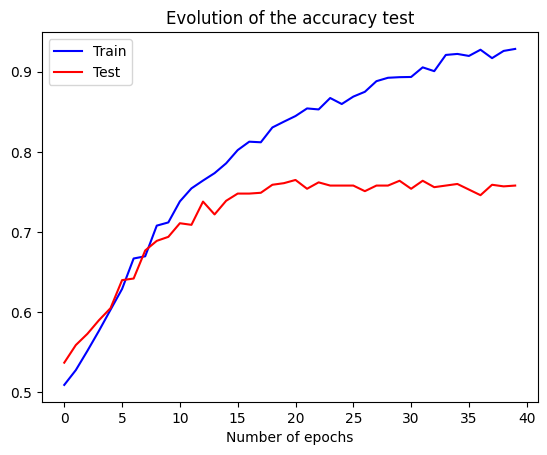

In [ ]:
plt.plot(np.arange(40), acc[0,:], color='blue', label='Train')
plt.plot(np.arange(40), acc[1,:], color='red', label='Test')
plt.xlabel('Number of epochs')
plt.title('Evolution of the accuracy test')
plt.legend()
plt.show()

# Compare of our best Word2Vec model to the naive Classification model

In this part of the code we train our best model for more epochs

  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 0, Loss:0.04445955880731344 and accuracy 0.5405


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 1, Loss:0.037439941465854644 and accuracy 0.68725


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 2, Loss:0.031228185072541235 and accuracy 0.77525


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 3, Loss:0.024772985689342022 and accuracy 0.83425


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 4, Loss:0.018820322200655937 and accuracy 0.88825


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 5, Loss:0.014880694479681551 and accuracy 0.9175


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 6, Loss:0.012787992051802576 and accuracy 0.92975


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 7, Loss:0.011219718017615378 and accuracy 0.9375


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 8, Loss:0.00988640615902841 and accuracy 0.948


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 9, Loss:0.00819408373022452 and accuracy 0.96


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 10, Loss:0.008392109083244576 and accuracy 0.9525


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 11, Loss:0.007624794253148139 and accuracy 0.95425


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 12, Loss:0.007117324887309223 and accuracy 0.959


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 13, Loss:0.0062299980542156845 and accuracy 0.965


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 14, Loss:0.006416587377665564 and accuracy 0.965


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 15, Loss:0.005289535937365144 and accuracy 0.96925


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 16, Loss:0.005250296287238598 and accuracy 0.971


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 17, Loss:0.004756940466992091 and accuracy 0.973


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 18, Loss:0.004920837440644391 and accuracy 0.97325


  0%|          | 0/250 [00:00<?, ?it/s]

For the epoch 19, Loss:0.004996287195943296 and accuracy 0.974


  0%|          | 0/63 [00:00<?, ?it/s]

The validation accuracy is 0.704


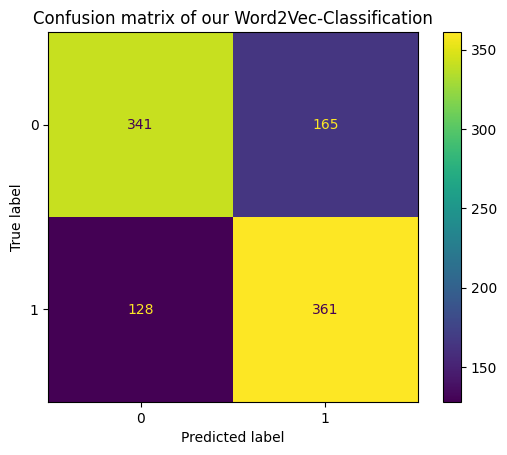

In [ ]:
n_epochs = 20
bestmodel = Conv1dClassifier(path = "/content/model_dim-100_radius-4_ratio-2-batch-256-epoch-3.ckpt",
    vocab_size = VOCSIZE, embedding_dim = 100)

training9 = training(n_epochs, bestmodel, train_dataloader, valid_dataloader )
preds_conf2 = training9[0].to(dtype=torch.int32).numpy()
labels_conf2 = training9[1].to(dtype=torch.int32).numpy()
cm2 = confusion_matrix(labels_conf2, preds_conf2, labels=np.array([0,1]))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array([0,1]))
disp2.plot()
plt.title('Confusion matrix of our Word2Vec-Classification')
plt.show()

# A look to our pretrained Word2Vec model with more data

We would also like to use the model which takes into account more samples in the training of the embeddings. We decide to select the hyper parameters from our best model(emb_dim = 100, Radius = 4, Ratio=2)

In [ ]:
acc_2 = valid_acc_num_epochs(40, Conv1dClassifier(path = "/content/best_model_dim-100_radius-4_ratio-2-batch-256-epoch-3.ckpt",
                                                vocab_size = VOCSIZE, embedding_dim = 100))

  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 0 and acc : 0.503


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.54


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 1 and acc : 0.536


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.553


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 2 and acc : 0.567


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.566


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 3 and acc : 0.577


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.577


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 4 and acc : 0.62


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.586


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 5 and acc : 0.6335


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.597


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 6 and acc : 0.6555


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.621


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 7 and acc : 0.6745


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.633


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 8 and acc : 0.7115


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.65


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 9 and acc : 0.722


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 10 and acc : 0.73825


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.687


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 11 and acc : 0.761


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.684


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 12 and acc : 0.77375


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.708


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 13 and acc : 0.77875


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.706


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 14 and acc : 0.80125


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.7


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 15 and acc : 0.81025


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.709


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 16 and acc : 0.828


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.713


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 17 and acc : 0.8315


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.716


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 18 and acc : 0.844


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.716


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 19 and acc : 0.85


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.713


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 20 and acc : 0.85375


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.719


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 21 and acc : 0.8575


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.717


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 22 and acc : 0.87675


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.722


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 23 and acc : 0.8775


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.721


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 24 and acc : 0.87975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.713


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 25 and acc : 0.893


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.724


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 26 and acc : 0.89825


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.724


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 27 and acc : 0.89875


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.721


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 28 and acc : 0.90475


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.731


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 29 and acc : 0.90975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.73


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 30 and acc : 0.9155


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.735


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 31 and acc : 0.9205


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.728


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 32 and acc : 0.91875


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.73


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 33 and acc : 0.9255


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.726


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 34 and acc : 0.91975


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.716


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 35 and acc : 0.9315


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.735


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 36 and acc : 0.93175


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.726


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 37 and acc : 0.9385


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.734


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 38 and acc : 0.9395


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.72


  0%|          | 0/250 [00:00<?, ?it/s]

Finish train 39 and acc : 0.94325


  0%|          | 0/63 [00:00<?, ?it/s]

Acc test : 0.73


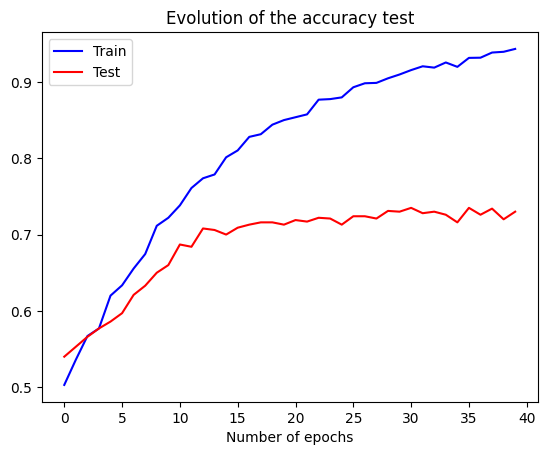

In [ ]:
plt.plot(np.arange(40), acc_2[0,:], color='blue', label='Train')
plt.plot(np.arange(40), acc_2[1,:], color='red', label='Test')
plt.xlabel('Number of epochs')
plt.title('Evolution of the accuracy test')
plt.legend()
plt.show()

As you can see from the above plot, we get a slight increase in the accuracy w.r.t the previous situation. After all, this is consistent with the theory because the **WORD2VEC** model needs a lot of samples to achieve a good performance. Unfortunately, we ran out of space in the report and so we cannot add this plot to it.